<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/08_pytorch_paper_replicating_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Experiment Tracking Exercises

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

In [1]:
from helper_functions import accuracy_fn, download_data, plot_decision_boundary, plot_loss_curves, plot_predictions, set_seeds
# from helper_functions import download_data, set_seeds, plot_loss_curves
from going_modular import engine, data_loaders
from going_modular import predictions
from going_modular.engine import train_step, test_step
from going_modular.utils import save_model
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import os
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random
import requests
import sklearn
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from torchinfo import summary
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import Accuracy, ConfusionMatrix
import torchvision
from torchvision import datasets

from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import Tuple, Dict, List
writer = SummaryWriter()
import zipfile



In [2]:
# all included in rprevious code. No need
# # No Change
# # Continue with regular imports
# import matplotlib.pyplot as plt
# import torch
# import torchvision

# from torch import nn
# from torchvision import transforms

# # Try to get torchinfo, install it if it doesn't work
# try:
#     from torchinfo import summary
# except:
#     print("[INFO] Couldn't find torchinfo... installing it.")
#     !pip install -q torchinfo
#     from torchinfo import summary

# # Try to import the going_modular directory, download it from GitHub if it doesn't work
# try:
#     # from going_modular.going_modular import data_setup, engine
#     from going_modular import data_loaders, engine
#     from helper_functions import download_data, set_seeds, plot_loss_curves
# except:
#     # Get the going_modular scripts
#     print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
#     !git clone https://github.com/mrdbourke/pytorch-deep-learning
#     !mv pytorch-deep-learning/going_modular .
#     !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
#     !rm -rf pytorch-deep-learning
#     from going_modular.going_modular import data_setup, engine
#     from helper_functions import download_data, set_seeds, plot_loss_curves

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/). 

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# # Continue with regular imports
# import matplotlib.pyplot as plt
# import torch
# import torchvision

# from torch import nn
# from torchvision import transforms

# # Try to get torchinfo, install it if it doesn't work
# try:
#     from torchinfo import summary
# except:
#     print("[INFO] Couldn't find torchinfo... installing it.")
#     !pip install -q torchinfo
#     from torchinfo import summary

# # Try to import the going_modular directory, download it from GitHub if it doesn't work
# try:
#     from going_modular.going_modular import data_setup, engine
#     from helper_functions import download_data, set_seeds, plot_loss_curves
# except:
#     # Get the going_modular scripts
#     print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
#     !git clone https://github.com/mrdbourke/pytorch-deep-learning
#     !mv pytorch-deep-learning/going_modular .
#     !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
#     !rm -rf pytorch-deep-learning
#     from going_modular.going_modular import data_setup, engine
#     from helper_functions import download_data, set_seeds, plot_loss_curves

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [17]:
# No Change
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [18]:
# No Change
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [19]:
# No Change
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [21]:
# No Change
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_loaders.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x249f72b6130>,
 ['pizza', 'steak', 'sushi'])

In [22]:
# No Change
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

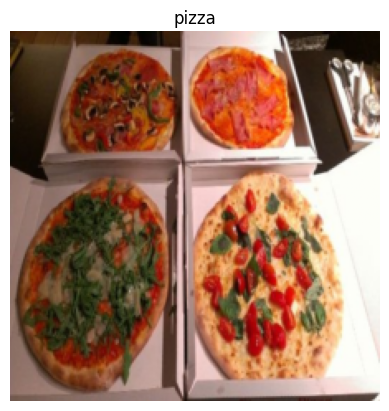

In [23]:
# NO change
#  Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks). 
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

In [24]:
rand_image_tensor = torch.randn(32, 3, 224, 224) # (batch_size, color_channels, height, width)
rand_image_tensor.shape

torch.Size([32, 3, 224, 224])

In [14]:
# # mine ecoded
# class PatchEmbedding (nn.Module):
#     def __init__(self,
#                  in_channels:int = 3,
#                  patch_size:int=16,
#                  embedding_dim:int=768):
#         super().__init__()

#         self.patch_size = patch_size

#         self.patcher = nn.Conv2d(in_channels=in_channels,
#                              out_channels=embedding_dim,
#                              kernel_size=patch_size,
#                              stride=patch_size,
#                              padding = 0)
    
#         self.flatten = nn.Flatten(start_dim = 2,
#                               end_dim = 3)
    
#     def forward (self, x):

#         image_resolution = x.shape [-1]
#         assert image_resolution % self.patch_size == 0, f'image size must be divisible {image_resolution}, and {patch_size}'

#         x_patched = self.patcher(x)
#         x_flattened = self.flatten(x_patched)

#         return x_flattened.permute (0, 2, 1)





In [25]:
# nochange
# from solution
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        self.patch_size = patch_size
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [16]:
# # mine
# patch_embedding = PatchEmbedding(patch_size=16)
# rand_image_tensor = torch.randn(32, 3, 224, 224)
# patch_embedding_output = patch_embedding(rand_image_tensor)
# print (f'input shape {rand_image_tensor.shape}')
# print (f'output shape {patch_embedding_output.shape}')

In [26]:
# from class
# no change
patch_embedding = PatchEmbedding(patch_size=16)
patch_embedding_output = patch_embedding(rand_image_tensor)
print(f"Input shape: {rand_image_tensor.shape}")
print(f"Output shape: {patch_embedding_output.shape} -> (batch_size, num_patches, embedding_dim)") 

Input shape: torch.Size([32, 3, 224, 224])
Output shape: torch.Size([32, 196, 768]) -> (batch_size, num_patches, embedding_dim)


## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/). 


In [18]:
# TODO: your code

In [19]:
# # TODO: your code
# my code
# torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
#                                            nhead=12,
#                                            dim_feedforward=3072,
#                                            dropout =0.1,
#                                            activation='gelu',
#                                            batch_first = True,
#                                            norm_first = True)
# # src = torch.rand(10, 32, 512)
# # out = encoder_layer(src)
# torch_transformer_encoder_layer

In [27]:
# Hyperparameters from Table 1 and Table 3 for ViT-Base
# no change
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                       nhead=12,
                                                       dim_feedforward=3072,
                                                       dropout=0.1,
                                                       activation="gelu",
                                                       batch_first=True,
                                                       norm_first=True)
transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [21]:
# from torchinfo import summary 

# summary(model=transformer_encoder_layer,
#         input_size=patch_embedding_output.shape)

In [22]:
# summary(model=torch_transformer_encoder_layer,
#         input_size = (1, 197, 768),
#         col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
#         col_width=20,
#         row_settings=['var_names'],
#         depth = 3)

In [14]:
# no change
from torchinfo import summary 

summary(model=transformer_encoder_layer,
        input_size=patch_embedding_output.shape, depth=4)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderLayer                  [32, 196, 768]            7,087,872
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 19.27
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 19.27

## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets) 
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [28]:
# TODO: your code
transformer_encoder = nn.TransformerEncoder(
    encoder_layer=transformer_encoder_layer,
    num_layers=12)

transformer_encoder


c:\Users\Hassan\anaconda3\envs\Py310UdemyCuda\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerEncoder(
  (layers): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)

In [29]:
summary(model=transformer_encoder,
        input_size=patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoder                       [32, 196, 768]            --
├─ModuleList: 1-1                        --                        --
│    └─TransformerEncoderLayer: 2-1      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-2      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-3      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-4      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-5      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-6      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-7      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-8      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-9      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-10     [32, 196, 768]            7,087,872
│    └─Transfor

## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [25]:
# TODO: your code
transformer_encoder = nn.TransformerEncoder(
    encoder_layer=transformer_encoder_layer,
    num_layers=12)

c:\Users\Hassan\anaconda3\envs\Py310UdemyCuda\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [26]:
summary(model = transformer_encoder,
        input_ize = patch_embedding_output.shape)

Layer (type:depth-idx)                                       Param #
TransformerEncoder                                           --
├─ModuleList: 1-1                                            --
│    └─TransformerEncoderLayer: 2-1                          --
│    │    └─MultiheadAttention: 3-1                          2,362,368
│    │    └─Linear: 3-2                                      2,362,368
│    │    └─Dropout: 3-3                                     --
│    │    └─Linear: 3-4                                      2,360,064
│    │    └─LayerNorm: 3-5                                   1,536
│    │    └─LayerNorm: 3-6                                   1,536
│    │    └─Dropout: 3-7                                     --
│    │    └─Dropout: 3-8                                     --
│    └─TransformerEncoderLayer: 2-2                          --
│    │    └─MultiheadAttention: 3-9                          2,362,368
│    │    └─Linear: 3-10                                     2,36

# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things. 
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **ImageNet-21k pretraining** 
    * **Learning rate warmup** 
    * **Learning rate decay** 
    * **Gradient clipping** 

In [27]:
# TODO: your explanations of the above terms
class ViT (nn.Module):
    def __init__ (self,
                  img_size: int = 224,#
                  in_channels:int = 3,#
                  patch_size: int=16,#
                  num_transformer_layers:int= 12,#
                  embedding_dim:int=768,#
                  mlp_size:int=3072,#
                  num_head:int = 12,#
                  attn_head:int= 12,
                #   attn_dropout:float= 0,
                  mlp_dropout:float = 0.1,
                  embedding_dropout:float= 0.1,
                  num_classes:int=1000#
                  ):
        super().__init__()

        assert img_size % patch_size == 0, f'image size must be divisiopbe by miage size {img_size}, patch_size {patch_size}'
        self.num_patches = (img_size * img_size)//patch_size**2
        self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim),
                                            requires_grad = True)
        self.position_embedding = nn.Parameter(data=torch.randn(1,1, embedding_dim),
                                               requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                            #   patch_size=in_channels,
                                              patch_size = patch_size,
                                              embedding_dim=embedding_dim)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_head,
                                                                            mlp_size=mlp_size,
                                                                            mlsp_dropout=mlp_dropout) for _ in range (num_transformer_layers)])
        
        self.classifier = nn.Sequentail(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim),
            out_features=num_classes
        )

    def forward (self, x):
        batch_size = x.shape[0]
        class_token = sefl.class_embeding.expand(batch_size, -1, -1)
        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim = 1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])
        return x
        


In [28]:
demo_img = torch.randn (1, 3, 244, 244).to(device)
print (demo_img.shape)
vit = ViT(num_classes=(class_names)).to(device)
vit(demo_img)

torch.Size([1, 3, 244, 244])


NameError: name 'TransformerEncoderBlock' is not defined